### Libraries

In [2]:
pip install plotly


                                              0.0/15.5 MB ? eta -:--:--
                                             0.0/15.5 MB 640.0 kB/s eta 0:00:25
                                             0.1/15.5 MB 465.5 kB/s eta 0:00:34
                                             0.1/15.5 MB 403.5 kB/s eta 0:00:39
                                             0.1/15.5 MB 435.7 kB/s eta 0:00:36
                                             0.1/15.5 MB 425.3 kB/s eta 0:00:37
                                             0.2/15.5 MB 416.7 kB/s eta 0:00:37
                                             0.2/15.5 MB 402.6 kB/s eta 0:00:39
                                             0.2/15.5 MB 401.2 kB/s eta 0:00:39
                                             0.2/15.5 MB 416.7 kB/s eta 0:00:37
                                             0.3/15.5 MB 402.9 kB/s eta 0:00:38
                                             0.3/15.5 MB 402.9 kB/s eta 0:00:38
                                             0.3


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score

import tensorflow as tf

## Get Positive & Negative **Directories**

In [4]:
positive_dir = Path(r'D:\\Varsity\\Thesis\\dataset\\training\\Concrete\\Positive')
negative_dir = Path(r'D:\\Varsity\\Thesis\\dataset\\training\\Concrete\\Negative')

### Creating DataFrames

In [5]:
def generate_df(img_dir, label):

    file_paths = pd.Series(list(img_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=file_paths.index)
    df = pd.concat([file_paths, labels], axis=1)

    return df

In [6]:
positive_df = generate_df(positive_dir, 'POSITIVE')
negative_df = generate_df(negative_dir, 'NEGATIVE')

# concatenate both positive and negative df
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,D:\Varsity\Thesis\dataset\training\Concrete\Po...,POSITIVE
1,D:\Varsity\Thesis\dataset\training\Concrete\Po...,POSITIVE
2,D:\Varsity\Thesis\dataset\training\Concrete\Po...,POSITIVE
3,D:\Varsity\Thesis\dataset\training\Concrete\Ne...,NEGATIVE
4,D:\Varsity\Thesis\dataset\training\Concrete\Po...,POSITIVE
...,...,...
39995,D:\Varsity\Thesis\dataset\training\Concrete\Po...,POSITIVE
39996,D:\Varsity\Thesis\dataset\training\Concrete\Ne...,NEGATIVE
39997,D:\Varsity\Thesis\dataset\training\Concrete\Po...,POSITIVE
39998,D:\Varsity\Thesis\dataset\training\Concrete\Po...,POSITIVE


### Split the DataSet

In [7]:
train_df, test_df = train_test_split(all_df.sample(6000, random_state=1),
                train_size=0.7,
                shuffle=True,
                random_state=1)

### Loading Image Data

In [8]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
train_data = train_gen.flow_from_dataframe(train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=True,
                                          seed=42,
                                          subset='training')


val_data = train_gen.flow_from_dataframe(train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=True,
                                          seed=42,
                                          subset='validation')


test_data = test_gen.flow_from_dataframe(test_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=False,
                                          seed=42)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [10]:
test_data

### Training DataSet

In [11]:
inputs = tf.keras.Input(shape=(120,120,3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [12]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [14]:
# print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [15]:
history = model.fit(train_data, validation_data=val_data, epochs=50,
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=3,
                                                              restore_best_weights=True)
                             ])

Epoch 1/50
105/105 [==============================] - 198s 2s/step - loss: 0.6762 - accuracy: 0.6036 - val_loss: 0.6478 - val_accuracy: 0.7690
Epoch 2/50
105/105 [==============================] - 38s 363ms/step - loss: 0.6132 - accuracy: 0.6807 - val_loss: 0.5800 - val_accuracy: 0.7810
Epoch 3/50
105/105 [==============================] - 31s 292ms/step - loss: 0.5269 - accuracy: 0.8140 - val_loss: 0.4863 - val_accuracy: 0.8726
Epoch 4/50
105/105 [==============================] - 29s 272ms/step - loss: 0.4453 - accuracy: 0.8741 - val_loss: 0.3966 - val_accuracy: 0.9083
Epoch 5/50
105/105 [==============================] - 38s 361ms/step - loss: 0.3586 - accuracy: 0.9122 - val_loss: 0.3136 - val_accuracy: 0.9429
Epoch 6/50
105/105 [==============================] - 34s 324ms/step - loss: 0.3032 - accuracy: 0.9244 - val_loss: 0.2621 - val_accuracy: 0.9560
Epoch 7/50
105/105 [==============================] - 33s 315ms/step - loss: 0.2466 - accuracy: 0.9408 - val_loss: 0.2248 - val_accu

### Plotting

In [16]:
fig = px.line(history.history,
             y=['loss', 'val_loss'],
             labels={'index':'Epoch'},
             title='Training and Validation Loss over Time')

fig.show()

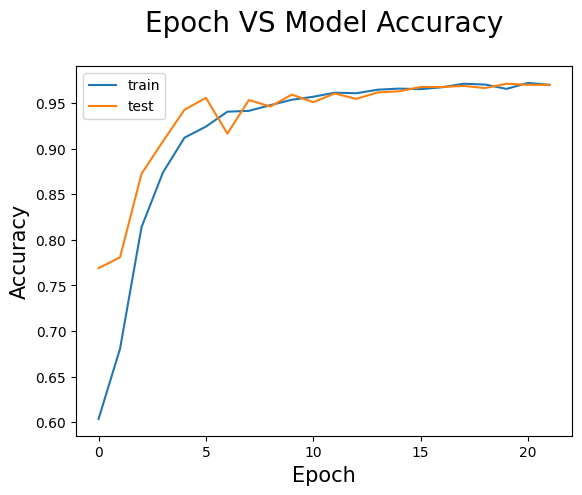

In [20]:
# This graph show Accuracy overtime from the begining to ending of training.
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Epoch VS Model Accuracy', size=20, pad=25)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Epoch VS Model Accuracy in MobileNetV2.png')

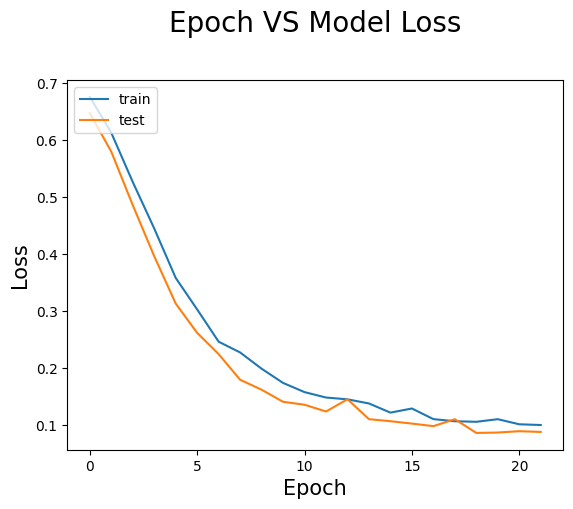

<Figure size 640x480 with 0 Axes>

In [21]:
plt.subplot(1,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epoch VS Model Loss', size=20, pad=35)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('Epoch VS Model Loss in MobileNetV2.png')

### Final Result

In [17]:
def evaluate_model(model, test_data):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    accuracy = results[1]

    print(f'Test Loss {loss:.5f}')
    print(f'Test Accuracy {accuracy * 100:.2f} %')


    # predicted y values
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    y_certain = np.squeeze((model.predict(test_data)).astype(np.int))

    conf_matr = confusion_matrix(test_data.labels, y_pred)

    class_report = classification_report(test_data.labels, y_pred,
                                         target_names=['NEGATIVE', 'POSITIVE'])

    plt.figure(figsize=(6,6))

    sns.heatmap(conf_matr, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')

    plt.xticks(ticks=np.arange(2) + 0.5, labels=['NON-CRACK', 'CRACK'])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=['NON-CRACK', 'CRACK'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print('r2 Score : ', r2_score(test_data.labels, y_pred))
    print()
    print('Classification Report :\n...............................................\n', class_report)

Test Loss 0.08165
Test Accuracy 97.39 %
57/57 [==============================] - 12s 196ms/step


C:\Users\Noman\AppData\Local\Temp\ipykernel_2200\1564942326.py:12: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



57/57 [==============================] - 9s 147ms/step


C:\Users\Noman\AppData\Local\Temp\ipykernel_2200\1564942326.py:13: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



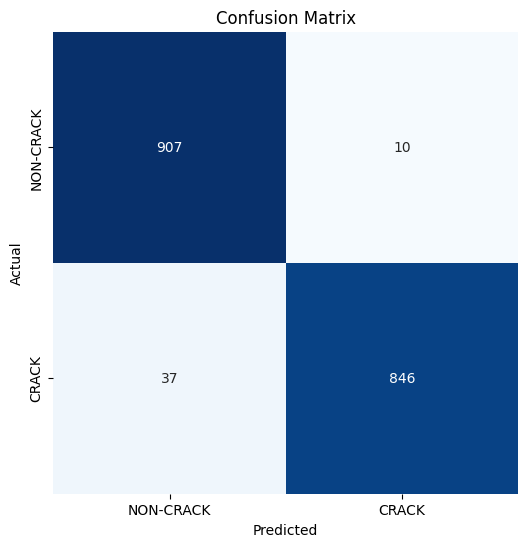

r2 Score :  0.895518277508889

Classification Report :
...............................................
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.99      0.97       917
    POSITIVE       0.99      0.96      0.97       883

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



In [18]:
evaluate_model(model, test_data)

### Testing New Dataset

In [19]:
def test_new_data(dir_path):

    new_test_dir = Path(dir_path)

    df_new = generate_df(new_test_dir, 'Testing')

    test_data_new = test_gen.flow_from_dataframe(df_new,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          batch_size=5,
                                          shuffle=False,
                                          seed=42)

        # predicted y values
    y_pred = np.squeeze((model.predict(test_data_new) >= 0.5).astype(np.int))


    y_certain = model.predict(test_data_new).round(6)
    y_out = []
    for i in y_pred:
        if i==0:
            y_out.append('Negative (Not Crack)')
        else:
            y_out.append('Positive(Crack) ')

    result = pd.DataFrame(np.c_[y_out, y_certain], columns=['Result', 'Confidance of being Cracked'])

    print(result)
    return result